# Расчет доли леса на спутниковом изображении

## Подготовка модели и пайплайна

Импортирование библиотек

In [1]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from srr.batchflow import FilesIndex, Dataset, Pipeline, V, B
from srr.batchflow.models.tf import UNet

from srr import AerialBatch
from srr.core.utils import get_origs, ce_dice_loss, make_mask, gather_image

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


Загрузка датасета

In [2]:
ind = FilesIndex(path='../ignore/deepglobe/train/*_sat.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=False)

Настройка параметров пайплайна и загрузка обученной модели

In [3]:
classes=(2,)
crop_shape = (256, 256)

In [4]:
MODEL_PATH = '../ignore/models/forest_2c_8_16_32_64_128_300ep/'

load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

Определение пайплайна

In [5]:
image_template = (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(lambda x: x, src='images', dst='orig_images')
      .apply_transform(lambda x: x, src='masks', dst='orig_masks')
      .apply_transform(get_origs, crop_shape=crop_shape, p=1.0, classes=classes, src='masks', dst='origs')
      .make_crops(size=crop_shape, src='images', dst='images')
      .make_crops(size=crop_shape, src='masks', dst='masks')
      .unstack_crops()
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('batch_predictions', init_on_each_run=list)
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('batch_predictions')], mode='w')
      .gather_metrics('segmentation', targets=B('masks'), predictions=V('batch_predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', V('batch_predictions'), mode='e')
).run(1, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/forest_2c_8_16_32_64_128_300ep/model-24000


Инференс на тестовой части датасета

In [6]:
image_pipeline = (image_template << ads.test)

## Подбор порога на тестовой части датасета

In [8]:
images = []
masks = []
forests = []

for _ in tqdm(range(len(ads.test))):
    image_batch = image_pipeline.next_batch(batch_size=1)
    
    y_pred = image_pipeline.get_variable('batch_predictions')

    img, mask, pred = gather_image(image_batch, y_pred, crop_shape=crop_shape)

    img = img[:1224,:1224,:]
    mask = mask[:1224,:1224,1]
    forest = pred[:1224,:1224,1]
    
    images.append(img)
    masks.append(mask)
    forests.append(forest)

100%|██████████| 161/161 [02:08<00:00,  1.20s/it]


In [21]:
from sklearn.metrics import f1_score, jaccard_similarity_score

In [28]:
opts = np.arange(0, 0.2, 0.01)

In [29]:
f1 = []
j = []
for thr in tqdm(opts):
    N = len(masks)
    f1_agg = 0
    j_agg = 0
    for i in range(N):
        f1_agg += f1_score(masks[i].flatten(), forests[i].flatten()>thr)
        j_agg += jaccard_similarity_score(masks[i].flatten(), forests[i].flatten()>thr)
    f1.append(f1_agg / N)
    j.append(j_agg / N)

100%|██████████| 20/20 [16:54<00:00, 50.88s/it]


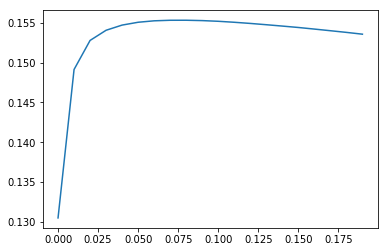

In [30]:
plt.plot(opts, f1)

In [32]:
opts[np.argmax(f1)]

# Прогноз на валидационной части датасета

In [61]:
ind = FilesIndex(path='../ignore/deepglobe/valid/*_sat.jpg')
vds = Dataset(ind, AerialBatch)

In [57]:
ind = FilesIndex(path='../ignore/test/00000067_q_sat.jpg')
vds = Dataset(ind, AerialBatch)

In [62]:
def pred_ppl(flip):
    return (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .apply_transform(lambda x: x, src='images', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .flip('lr', p=flip)
      .flip('ud', p=flip)
      .apply_transform(lambda x: x, src='images', dst='orig_images')
      .apply_transform(lambda x: x, src='masks', dst='orig_masks')
      .make_crops(size=crop_shape, src='images', dst='images')
      .make_crops(size=crop_shape, src='masks', dst='masks')
      .unstack_crops()
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(lambda x: x[:,:,:1], src='masks', dst='masks')
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('batch_predictions', init_on_each_run=list)
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('batch_predictions')], mode='w')
      .gather_metrics('segmentation', targets=B('masks'), predictions=V('batch_predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', V('batch_predictions'), mode='e')
).run(1, n_epochs=1, lazy=True)

In [63]:
# image_pipeline = (image_template << vds)
image_pipeline = (pred_ppl(0) << vds)
image_pipeline_flip = (pred_ppl(1) << vds)

INFO:tensorflow:Restoring parameters from ../ignore/models/forest_2c_8_16_32_64_128_300ep/model-24000
INFO:tensorflow:Restoring parameters from ../ignore/models/forest_2c_8_16_32_64_128_300ep/model-24000


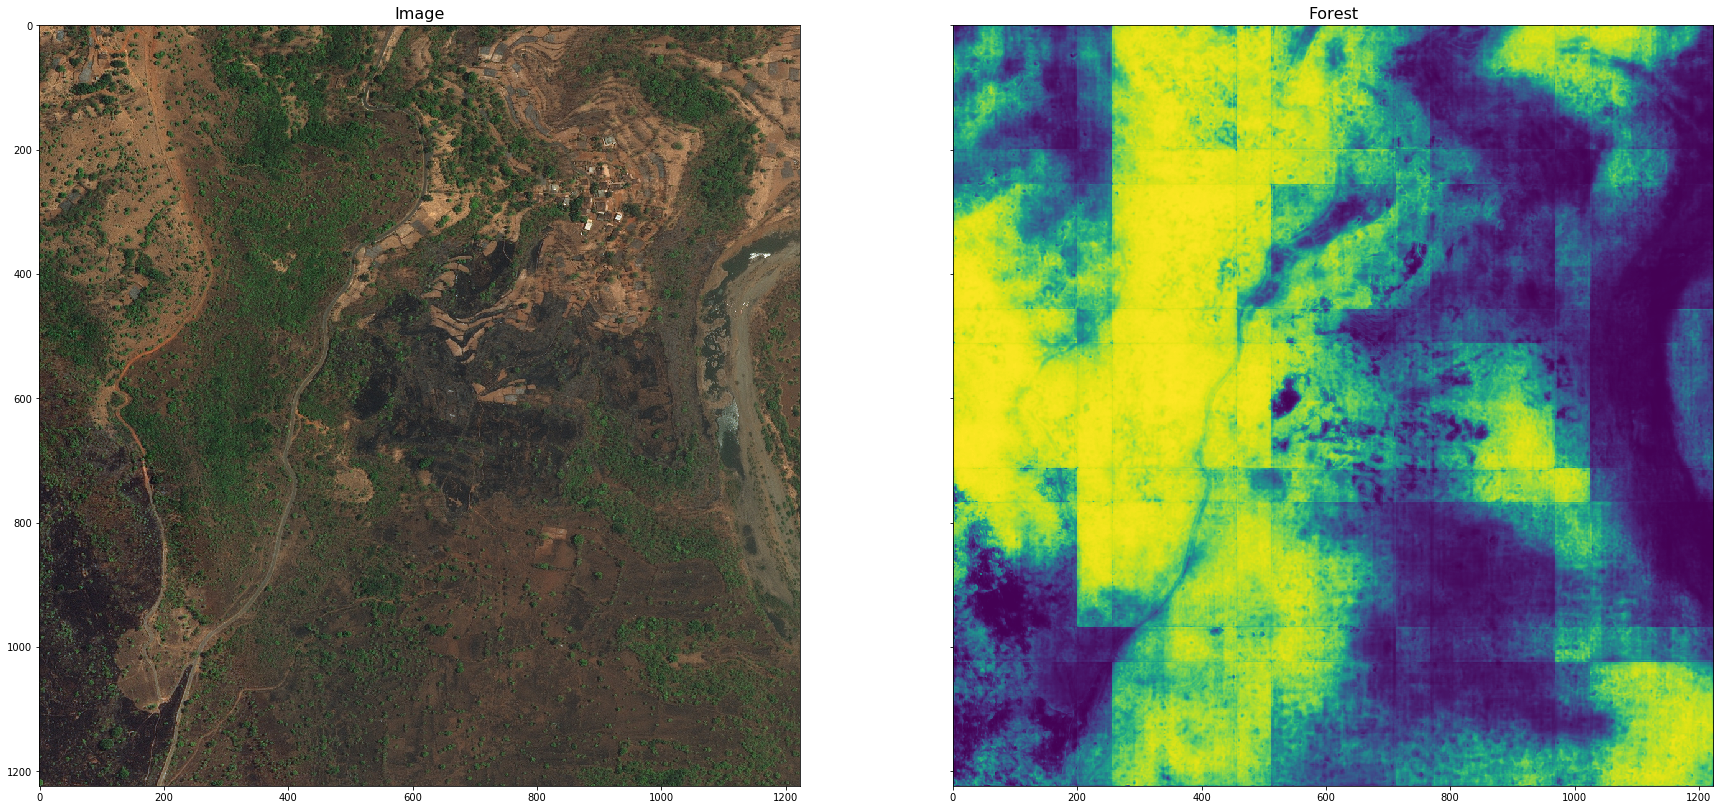

Доля леса на изображении: от 50.62% до 87.17%


In [128]:
image_batch = image_pipeline.next_batch(batch_size=1)
image_batch_flip = image_pipeline_flip.next_batch(batch_size=1)

y_pred = image_pipeline.get_variable('batch_predictions')
y_pred_flip = image_pipeline_flip.get_variable('batch_predictions')

img, mask, pred = gather_image(image_batch, y_pred, crop_shape=crop_shape)
_, _, pred_flip = gather_image(image_batch_flip, y_pred_flip, crop_shape=crop_shape)


img = img[:1224,:1224,:]
mask = mask[:1224,:1224,1]
forest = pred[:1224,:1224,1]
forest_flip = pred_flip[:1224,:1224,1]
forest_flip = forest_flip[::-1,::-1]

forest = (forest * forest_flip) ** 0.5

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,30), sharey=True)
ax1.imshow(img)
ax1.set_title('Image',size=16)
ax2.imshow(forest)
ax2.set_title('Forest',size=16)
plt.show()
print("Доля леса на изображении: от {:.2f}% до {:.2f}%".format((np.sum(forest>0.5) / forest.size) * 100, (np.sum(forest>0.08) / forest.size) * 100))